Required libraries:

In [47]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
import soundfile as sf
import warnings
import random
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

warnings.filterwarnings("ignore")

Data preprocessing:

Data from: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

In [48]:
train_dataset = './input/'
labels = os.listdir(train_dataset)
for label in labels:
    if not os.path.isdir(train_dataset + '/' + label):
        labels.remove(label)
labels.remove('_background_noise_')

print(labels)


['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [49]:
all_waves = []
all_labels = []
for label in labels:
    print("Preprocessing {}...".format(label))
    waves = [f for f in os.listdir(train_dataset + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_dataset + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(np.asarray(samples,dtype=np.float32), orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_waves.append(samples)
            all_labels.append(label)

Preprocessing bed...
Preprocessing bird...
Preprocessing cat...
Preprocessing dog...
Preprocessing down...
Preprocessing eight...
Preprocessing five...
Preprocessing four...
Preprocessing go...
Preprocessing happy...
Preprocessing house...
Preprocessing left...
Preprocessing marvin...
Preprocessing nine...
Preprocessing no...
Preprocessing off...
Preprocessing on...
Preprocessing one...
Preprocessing right...
Preprocessing seven...
Preprocessing sheila...
Preprocessing six...
Preprocessing stop...
Preprocessing three...
Preprocessing tree...
Preprocessing two...
Preprocessing up...
Preprocessing wow...
Preprocessing yes...
Preprocessing zero...


In [50]:
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = le.classes_

In [51]:
y = to_categorical(y, num_classes=len(labels))

In [52]:
X = np.array(all_waves).reshape(-1, 8000, 1)

In [53]:
print(X.shape)
print(y.shape)

(58252, 8000, 1)
(58252, 30)


In [54]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777, shuffle=True)

Model

In [55]:
K.clear_session()

inputs = Input(shape=(8000, 1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 7988, 8)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2662, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2652, 16)       │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 884, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 876, 32)        │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 292, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 286, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 95, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,556,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,614,078 (6.16 MB)

 Trainable params: 1,614,078 (6.16 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
num_epoch = 30

In [57]:
history=model.fit(X_train, y_train ,epochs=num_epoch, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))

Epoch 1/30
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0951 - loss: 3.1074
Epoch 1: val_accuracy improved from -inf to 0.30530, saving model to best_model.hdf5.keras
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 87s 57ms/step - accuracy: 0.0951 - loss: 3.1072 - val_accuracy: 0.3053 - val_loss: 2.2399
Epoch 2/30
1456/1457 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3399 - loss: 2.0991
Epoch 2: val_accuracy improved from 0.30530 to 0.51412, saving model to best_model.hdf5.keras
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 90s 62ms/step - accuracy: 0.3400 - loss: 2.0989 - val_accuracy: 0.5141 - val_loss: 1.6458
Epoch 3/30
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4884 - loss: 1.6256
Epoch 3: val_accuracy improved from 0.51412 to 0.64406, saving model to best_model.hdf5.keras
1457/1457 ━━━━━━━━━━━━━━━━━━━━ 79s 54ms/step - accuracy: 0.4884 - loss: 1.6255 - val_accuracy: 0.6441 - val_loss: 1.2578
Epoch 4/30
1456/1457 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5670 - loss: 1.3935
Ep

Results

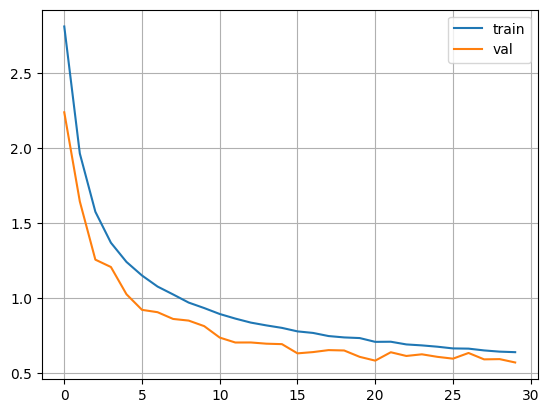

In [58]:
plt.figure()
plt.plot(range(num_epoch),history.history['loss'], label='train')
plt.plot(range(num_epoch),history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

Tests

In [59]:
model = load_model('best_model.hdf5.keras')

In [74]:
def predict(audio):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [61]:
index=random.randint(0,len(X_val)-1)
samples=X_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: up


In [62]:
print("Text:",predict(samples))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Text: up


Check your voice sample: 

In [85]:
samplerate = 16000
duration = 1
filename = 'voice.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)


start
end


In [86]:
#reading the voice commands
samples, sample_rate = librosa.load('voice.wav', sr = 16000)
samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
ipd.Audio(samples,rate=8000) 

In [87]:
result = predict(samples)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
up
